In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from numpy.linalg import solve
from scipy.stats import uniform

# SIO 112: Ch 7 examples

## Linear Example

In [ ]:
# domain
x = np.arange(-6,6,0.01)

# prior
mu = 1
sx = 1
po = (1/np.sqrt(2*np.pi)/sx) * np.exp(-0.5* ((x-mu)/sx)**2 )

#data and likelihood
sy = 0.5
h = 2
y = -1

#posterior
K = (sx**2*h) / (sx**2*h**2 + sy**2)
m_hat = mu + K*(y-h*mu)
varpost = (1-K*h)*sx**2
s_hat = np.sqrt(varpost)
ppost = (1/np.sqrt(2*np.pi)/s_hat) * np.exp(-.5* ((x-m_hat)/s_hat)**2)

#plot
plt.plot(x,po, label='Prior')
plt.plot(x,ppost, label='Posterior');
plt.axvline(x=-1, color='k', linestyle='--')
plt.legend()
plt.ylim([0,2])
plt.xlim([-6,6])
plt.xlabel('x')
plt.ylabel('pdf')
#plt.savefig('../figs/lin_ex.png',dpi=150);

## Seismic Example

In [128]:
# seis model 
def SeisModel(D):
    v = 25
    #x = np.vstack(np.linspace(-100,100,200))
    x = (np.linspace(-100,100,200))
    out = v/np.pi*np.arctan2(x,D)
    return out

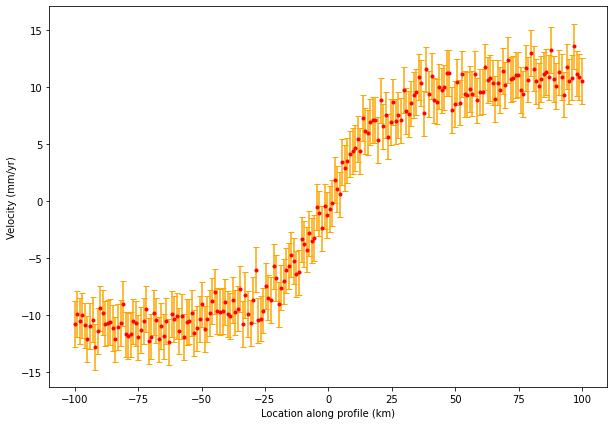

In [129]:
# load data
xdata = pd.read_csv('../data/SeimoEx_x.txt')
x = np.array((xdata.iloc[[0]].values)[0])
seisdata_sy = pd.read_csv('../data/SeimoEx_sy.txt')
s = np.array(seisdata_sy['s'])
y = np.array(seisdata_sy['y'])

# plot data 
plt.figure(figsize=([10,7]))
plt.errorbar(x,y,2*s, fmt='r.', ecolor='orange', capsize=3)
plt.xlabel('Location along profile (km)')
plt.ylabel('Velocity (mm/yr)');

C:\Users\trin\AppData\Local\Temp/ipykernel_25560/92621080.py:39: RuntimeWarning: overflow encountered in exp
  if rand < min([1, np.exp(logalpha)]):


Acceptance ratio: 0.24512490249804997


C:\Users\trin\AppData\Local\Temp/ipykernel_25560/92621080.py:66: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,int(1e5)])


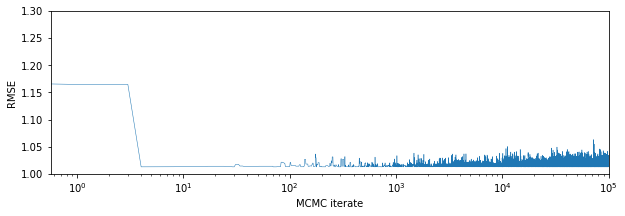

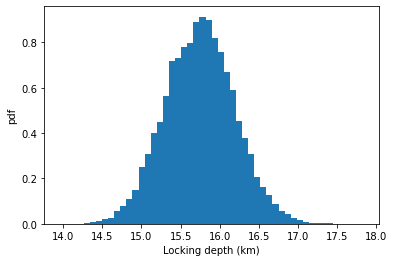

Posterior mean (km): 15.744884600951147
Posterior std. (km): 0.44308467783243005


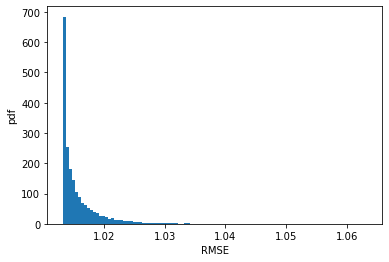

In [133]:
# MCMC

nSteps = int(1e5)
sig = 2.2

#  store locking depth
D = np.zeros(nSteps)
D[0] = 10

#  store associated velocities
Ys = np.zeros([len(y),nSteps])
yM = SeisModel(D[1])
Ys[:,0] = yM

# log of posterior for current state
log_p_d = -0.5*sum( ((y-yM)/s)**2 )

# store log of posterior values
logp = np.zeros(nSteps)
logp[0] = log_p_d

#store rmse
rmse = np.zeros(nSteps)
rmse[0] = np.sqrt( np.mean( ((y-yM)/s)**2 ) )

accMoves = 0 
for k in range(0,nSteps-1):
    # proposal 
    randn = np.random.normal(0,1)
    d_p = D[k] + sig*randn
    # accept/reject
    if d_p > 0: 
        #check prior
        yM = SeisModel(d_p)
        log_p_dp = -0.5*sum( ((y-yM)/s)**2 )
        logalpha = log_p_dp - log_p_d
        
        rand = np.random.uniform(0,1)
        if rand < min([1, np.exp(logalpha)]):
            #accept
            D[k+1] = d_p
            log_p_d = log_p_dp
            rmse[k+1] = np.sqrt( np.mean( ((y-yM)/s)**2 ) )
            Ys[:,k+1] = yM
            accMoves = accMoves+1
        else:
            #reject 
            D[k+1] = D[k]
            rmse[k+1] = rmse[k]
            Ys[:,k+1] = Ys[:,k]
    else:
        # reject bc proposal is outside of the prior
        D[k+1] = D[k]
        rmse[k+1] = rmse[k]
        Ys[:,k+1] = Ys[:,k]

print('Acceptance ratio:', accMoves/k)

# check burn in 
plt.figure(figsize=([10,3]))
plt.plot(rmse, lw=0.5)
plt.xscale("log")
plt.xlabel('MCMC iterate')
plt.ylabel('RMSE')
plt.ylim([1,1.3])
plt.xlim([0,int(1e5)])
plt.show()

# remove burn in
BurnIn = int(1e3)
rmse = rmse[BurnIn:]
D = D[BurnIn:]
logp = logp[BurnIn:]
Ys = Ys[:,BurnIn:]

# look at results
plt.hist(D,density=True,bins=50)
plt.xlabel('Locking depth (km)')
plt.ylabel('pdf')
plt.show()

# print out posterior mean and posterior std deviaiton
print('Posterior mean (km):', np.mean(D))
print('Posterior std. (km):', np.std(D))

# plot histogram of rmse
#plt.plot(rmse, uniform.pdf(rmse),'r',alpha=0.7, label='pdf') 
plt.hist(rmse,density=True,bins=100)
plt.xlabel('RMSE')
plt.ylabel('pdf');
plt.show()

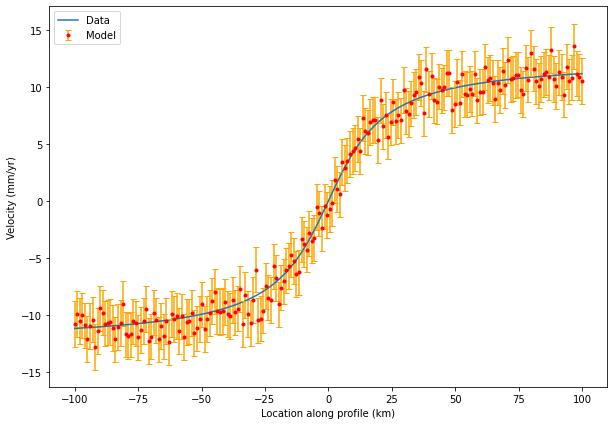

In [131]:
# plot a few samples of post
nSamp = 500
r = np.random.randint(low=1,high=(len(Ys[0])),size=nSamp)[0]
YPlot = Ys[:,r]

plt.figure(figsize=([10,7]))
plt.plot(x,YPlot)
plt.errorbar(x,y,2*s, fmt='r.', ecolor='orange', capsize=3)
plt.xlabel('Location along profile (km)')
plt.ylabel('Velocity (mm/yr)')
plt.legend(['Data','Model']);

# SIO 112: Ch 8 examples

## LinEx1

In [37]:
#load data
H = np.loadtxt('../data/LinEx1_H.txt', delimiter=',')
P = np.loadtxt('../data/LinEx1_P.txt', delimiter=',')
s = float(np.loadtxt('../data/LinEx1_s.txt'))
x = np.loadtxt('../data/LinEx1_x.txt', delimiter=',')
xy = np.loadtxt('../data/LinEx1_xy.txt', delimiter=',')
y = np.loadtxt('../data/LinEx1_y.txt', delimiter=',')

RLS RMSE = 0.07443574574734411
LS RMSE = 0.0


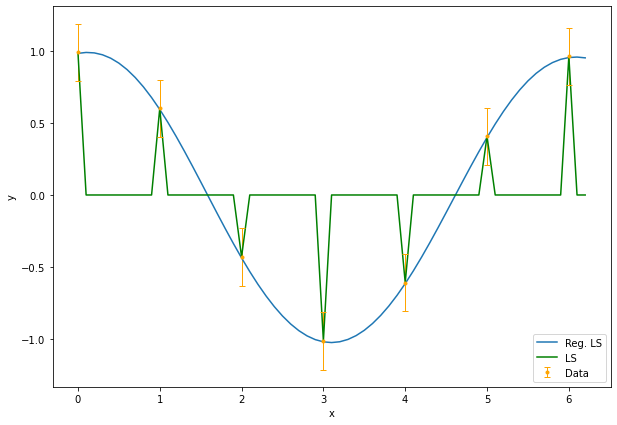

In [126]:
# regularized least squares
R = s**2
P_H = np.matmul(P,H.T).T
H_P_H = np.matmul( np.matmul(H,P), H.T )
m = np.matmul( ( solve((H_P_H + R),y) ),P_H )
yM = np.matmul(H,m)

rmse = np.sqrt(np.mean( ((y-yM)/s)**2 ) )
print('RLS RMSE =', rmse)

# compare to least squares
mLS = np.linalg.lstsq(H,y, rcond=None)[0]
yLS = np.matmul(H,mLS)

LS_rmse = np.sqrt(np.mean (((y-yLS)/s)**2 ) )
print('LS RMSE =', LS_rmse)

# plots
plt.figure(figsize=([10,7]))
plt.plot(x,m,'-', label='Reg. LS')
plt.plot(x,mLS,'g-', label='LS') 
plt.errorbar(xy,y,np.array(7*[2*s]),fmt='.',mfc=None,ecolor='orange', label='Data',lw=1,capsize=3, c='orange') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right');